In [22]:
import numpy as np
import math
from scipy.special import comb
import SimpleITK as sitk
import matplotlib.pyplot as plt

In [24]:
def tchebichef_polynomials(N, order):
    """
    Calcule les polynômes de Tchebichef de manière stable par récurrence.
    Remplace avantageusement la formule directe de l'Eq. (3).
    """
    M = np.zeros((order, N))
    x = np.arange(N)
    
    # p = 0
    M[0, :] = 1.0
    
    if order > 1:
        # p = 1
        M[1, :] = (2.0 * x - N + 1.0) / N
        
    # p > 1 : Relation de récurrence de Mukundan
    for p in range(2, order):
        term1 = ((2.0 * p - 1.0) * (2.0 * x - N + 1.0)) / (p * N)
        term2 = ((p - 1.0) / p) * (1.0 - ((p - 1.0)**2 / (N**2)))
        M[p, :] = term1 * M[p-1, :] - term2 * M[p-2, :]
        
    return M

def calculate_rho(N, order):
    """
    Calcule la constante de normalisation rho(p,N).
    Implémente la récurrence de l'Équation (4).
    """
    rho = np.zeros(order)
    rho[0] = N
    for p in range(1, order):
        # Formule récursive pour l'efficacité numérique
        term1 = (N**2 - p**2) / (N**2)
        term2 = (2*p - 1) / (2*p + 1)
        rho[p] = term1 * term2 * rho[p-1]
    return rho

In [25]:
def decompose_2d(image, order):
    """Décomposition robuste gérant les images rectangulaires."""
    H, W = image.shape
    M_h = tchebichef_polynomials(H, order)
    M_w = tchebichef_polynomials(W, order)
    
    rho_h = calculate_rho(H, order)
    rho_w = calculate_rho(W, order)
    
    T_raw = M_h @ image @ M_w.T
    C_pq = 1.0 / np.outer(rho_h, rho_w)
    return T_raw * C_pq

def reconstruct_2d(moments, shape_originale):
    """Reconstruction à partir des moments calculés."""
    H, W = shape_originale
    order = moments.shape[0]
    M_h = tchebichef_polynomials(H, order)
    M_w = tchebichef_polynomials(W, order)
    return M_h.T @ moments @ M_w

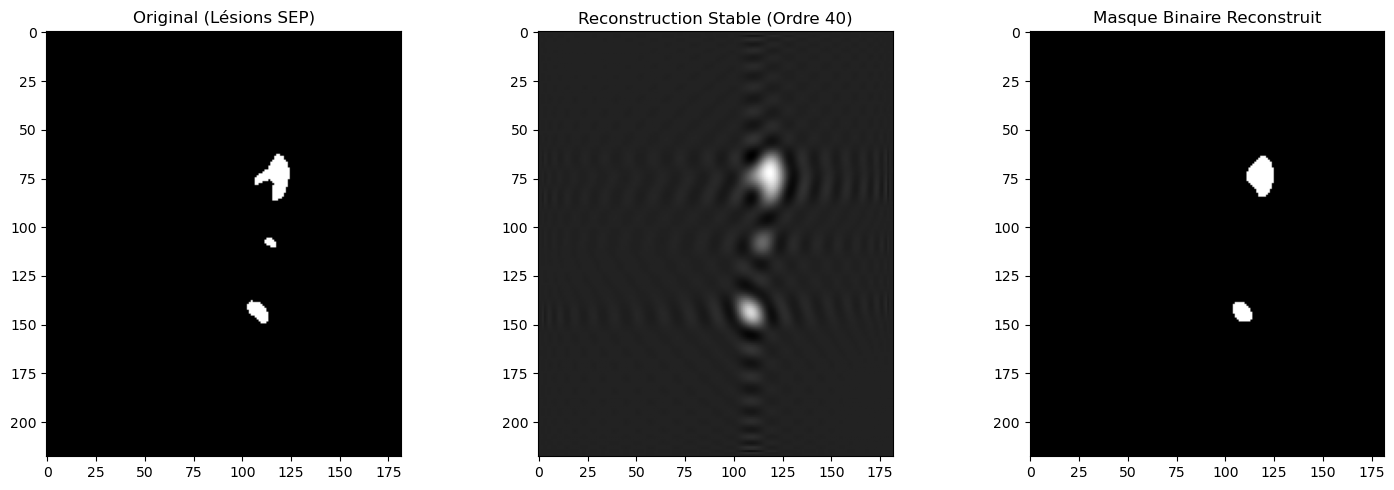

Erreur quadratique moyenne (MSE) : 2.399392e-03


In [26]:
# 1. Chargement des données (Chemin conservé)
mask_path = "../../27919209/MSLesSegDataset/train/P1/T1/P1_T1_MASK.nii.gz"
mask_sitk = sitk.ReadImage(mask_path)
mask_array = sitk.GetArrayFromImage(mask_sitk).astype(np.float32)

# 2. Extraction d'une coupe 2D
slice_idx = mask_array.shape[0] // 2
sample_slice = mask_array[slice_idx, :, :]

# Paramètres
ORDRE = 40 # Indispensable pour la précision des formes SEP [cite: 89, 140]

# 3. Décomposition / Reconstruction STABLE
moments_2d = decompose_2d(sample_slice, ORDRE)
reconstruction = reconstruct_2d(moments_2d, sample_slice.shape)

# Nettoyage (Seuillage)
mask_final = (reconstruction > 0.5).astype(np.uint8)

# 4. Affichage des résultats
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.title("Original (Lésions SEP)")
plt.imshow(sample_slice, cmap='gray')

plt.subplot(1, 3, 2)
plt.title(f"Reconstruction Stable (Ordre {ORDRE})")
plt.imshow(reconstruction, cmap='gray') # Utilisation de gray pour plus de clarté

plt.subplot(1, 3, 3)
plt.title("Masque Binaire Reconstruit")
plt.imshow(mask_final, cmap='gray')

plt.tight_layout()
plt.show()

# 5. Métrique de succès
mse = np.mean((sample_slice - reconstruction)**2)
print(f"Erreur quadratique moyenne (MSE) : {mse:.6e}")

In [28]:
def decompose_3d(volume, order):
    """
    Décomposition d'un volume 3D en moments de Tchebichef T_pqr.
    Supporte les volumes non-cubiques (D, H, W).
    """
    D, H, W = volume.shape
    
    # 1. Génération des bases pour chaque axe
    M_d = tchebichef_polynomials(D, order)
    M_h = tchebichef_polynomials(H, order)
    M_w = tchebichef_polynomials(W, order)
    
    # 2. Constantes de normalisation rho (Eq. 4)
    rho_d = calculate_rho(D, order)
    rho_h = calculate_rho(H, order)
    rho_w = calculate_rho(W, order)
    
    # 3. Triple projection (Somme pondérée)
    # p,q,r = ordres | i,j,k = coordonnées (z,y,x)
    T_raw = np.einsum('pi,qj,rk,ijk->pqr', M_d, M_h, M_w, volume)
    
    # 4. Application de C_pqr = 1 / (rho_p * rho_q * rho_r)
    C_pqr = 1.0 / (rho_d[:, None, None] * rho_h[None, :, None] * rho_w[None, None, :])
    return T_raw * C_pqr

def reconstruct_3d(moments, target_shape):
    """
    Reconstruction du volume 3D à partir des moments T_pqr.
    """
    D, H, W = target_shape
    order = moments.shape[0]
    
    M_d = tchebichef_polynomials(D, order)
    M_h = tchebichef_polynomials(H, order)
    M_w = tchebichef_polynomials(W, order)
    
    # Transformation inverse
    return np.einsum('pi,qj,rk,pqr->ijk', M_d, M_h, M_w, moments)

In [ ]:
# 1. Paramètres
ORDRE_3D = 20 # Commencer à 20 pour la 3D (suffisant pour capturer les formes)

# 2. Extraction d'une zone d'intérêt (ROI) 
# On prend un cube de 64x64x64 autour du centre pour le test
z, y, x = mask_array.shape
roi_size = 32
sample_volume = mask_array[z//2-roi_size:z//2+roi_size, 
                           y//2-roi_size:y//2+roi_size, 
                           x//2-roi_size:x//2+roi_size]

# 3. Calculs
print(f"Décomposition 3D (Ordre {ORDRE_3D})...")
moments_3d = decompose_3d(sample_volume, ORDRE_3D)

print("Reconstruction 3D...")
reconstruction_3d = reconstruct_3d(moments_3d, sample_volume.shape)

# 4. Visualisation (on affiche une coupe axiale au milieu du volume)
mid = roi_size
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.title("Original (ROI 3D - Coupe)")
plt.imshow(sample_volume[mid, :, :], cmap='gray')

plt.subplot(1, 3, 2)
plt.title(f"Reconstruction 3D (Ordre {ORDRE_3D})")
plt.imshow(reconstruction_3d[mid, :, :], cmap='gray')

plt.subplot(1, 3, 3)
plt.title("Masque Binaire Reconstruit (Seuil 0.5)")
plt.imshow(reconstruction_3d[mid, :, :] > 0.5, cmap='gray')

plt.show()

mse_3d = np.mean((sample_volume - reconstruction_3d)**2)
print(f"MSE 3D : {mse_3d:.6e}")